>>> START
DATA exists: True
TRAIN_IMG exists: True | TEST_IMG exists: True
TRAIN_CSV exists: True | SAMPLE_SUB exists: True
labels shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


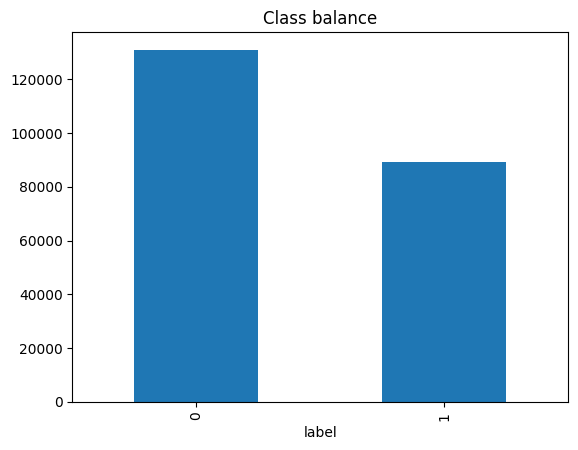

Device: cpu | train=2000 | val=500
Smoke batch shapes: (32, 3, 64, 64), (32,)
epoch 1 step 50/63
epoch 1 val_auc 0.9032
epoch 2 step 50/63
epoch 2 val_auc 0.8992
Saved: /kaggle/working/submission.csv
Log also saved to: /kaggle/working/run.log
Done!


In [4]:
# ==== CNN Cancer Detection Kaggle Mini-Project (PyTorch) ====

#==================================================================#



## Histopathologic Cancer Detection – Mini Project

## Goal: classify 96×96 pathology patches as tumor (1) or normal (0) using the Kaggle “Histopathologic Cancer Detection” dataset.
## Metric: ROC AUC. I use a simple ResNet-18 baseline.


    
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score





# --- print +  write to a log file 

LOGFILE = Path("/kaggle/working/run.log")
def log(msg):
    print(msg, flush=True)
    with open(LOGFILE, "a", encoding="utf-8") as f:
        f.write(str(msg) + "\n")


log(">>> START")





# --- paths

DATA = Path("/kaggle/input/histopathologic-cancer-detection")
TRAIN_IMG = DATA/"train"
TEST_IMG  = DATA/"test"
TRAIN_CSV = DATA/"train_labels.csv"
SAMPLE_SUB = DATA/"sample_submission.csv"
WORK = Path("/kaggle/working")
IMG_EXT = "tif"




## --- quick data checks
## - Source: Kaggle competition dataset (220,025 labeled train tiles + separate test).
## - Columns: `id` (image file stem), `label` (0/1).
## - I verify paths and show `head()`/shape below.


log(f"DATA exists: {DATA.exists()}")
log(f"TRAIN_IMG exists: {TRAIN_IMG.exists()} | TEST_IMG exists: {TEST_IMG.exists()}")
log(f"TRAIN_CSV exists: {TRAIN_CSV.exists()} | SAMPLE_SUB exists: {SAMPLE_SUB.exists()}")

df = pd.read_csv(TRAIN_CSV)
log(f"labels shape: {df.shape}")
log(df.head())





## EDA (brief)
## I am checking shape/head and the class balance bar chart.

df["label"].value_counts().plot(kind="bar", title="Class balance");
plt.show()




# --- splits

df_tr, df_va = train_test_split(df, test_size=0.1, stratify=df.label, random_state=42)
df_tr = df_tr.sample(2000, random_state=0)  
df_va = df_va.sample(500,  random_state=0)





# --- transforms

IMG_SIZE = 64
t_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
t_val = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])




# --- dataset

class HistoDS(Dataset):
    def __init__(self, df, folder, tfm, with_label=True):
        self.df = df.reset_index(drop=True)
        self.folder = folder
        self.tfm = tfm
        self.with_label = with_label
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        rid = self.df.loc[i, "id"]
        img = Image.open(self.folder/f"{rid}.{IMG_EXT}").convert("RGB")
        x = self.tfm(img)
        if self.with_label:
            y = torch.tensor(self.df.loc[i, "label"], dtype=torch.float32)
            return x, y
        return x, rid




# loaders

train_dl = DataLoader(HistoDS(df_tr, TRAIN_IMG, t_train, True), batch_size=32, shuffle=True,  num_workers=0)
val_dl   = DataLoader(HistoDS(df_va, TRAIN_IMG, t_val,   True), batch_size=64, shuffle=False, num_workers=0)



## Model & Training
## - Model: torchvision ResNet-18; final layer changed to 1 output (sigmoid at inference).
## - Loss: BCEWithLogitsLoss; Optimizer: Adam (lr=1e-3).
## - Input size: 64×64; augmentation: random horizontal flip.
## - Split: 90/10 (I trained on a small subset first for speed; can remove for full run).



# --- model

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

log(f"Device: {device} | train={len(df_tr)} | val={len(df_va)}")




# tests

xb, yb = next(iter(train_dl))
log(f"Smoke batch shapes: {tuple(xb.shape)}, {tuple(yb.shape)}")




# --- validation helper

def val_auc():
    model.eval()
    ys, ps = [], []
    with torch.inference_mode():
        for xb, yb in val_dl:
            xb = xb.to(device)
            p = torch.sigmoid(model(xb)).squeeze(1).cpu().numpy()
            ys.append(yb.numpy()); ps.append(p)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    return roc_auc_score(ys, ps)




# --- training

EPOCHS = 2
for e in range(EPOCHS):
    model.train()
    for i, (xb, yb) in enumerate(train_dl, 1):
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb).squeeze(1)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        if i % 50 == 0:
            log(f"epoch {e+1} step {i}/{len(train_dl)}")
    log(f"epoch {e+1} val_auc {round(val_auc(), 4)}")



## Results & Conclusion
## Validation AUC (subset run): **0.90 (≈0.9032 first epoch)**.  



# --- predicts

sub = pd.read_csv(SAMPLE_SUB) 
test_ds = HistoDS(sub[["id"]], TEST_IMG, t_val, with_label=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

model.eval()
all_p = []
with torch.inference_mode():
    for xb, _ids in test_dl:
        xb = xb.to(device)
        p = torch.sigmoid(model(xb)).squeeze(1).cpu().numpy()
        all_p.extend(p)

sub["label"] = all_p
out_path = WORK/"submission.csv"
sub.to_csv(out_path, index=False)
log(f"Saved: {out_path}")
log(f"Log also saved to: {LOGFILE}")


print("Done!")
